<a href="https://colab.research.google.com/github/sronak/Data_Science/blob/main/Gradient_Boosting_XGBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics 

pd.options.display.max_columns = False

%matplotlib inline

In [2]:
data = pd.read_csv('gender_classification.csv')
data.head()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,Male
1,0,14.0,5.4,0,0,1,0,Female
2,0,11.8,6.3,1,1,1,1,Male
3,0,14.4,6.1,0,1,1,1,Male
4,1,13.5,5.9,0,0,0,0,Female


In [3]:
data.shape

(5001, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 312.7+ KB


In [5]:
data.describe()

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
count,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000,5001.000000
mean,0.869626,13.181484,5.946311,0.493901,0.507898,0.493101,0.498900
std,0.336748,1.107128,0.541268,0.500013,0.499988,0.500002,0.500049
min,0.000000,11.400000,5.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,12.200000,5.500000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,13.100000,5.900000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,14.000000,6.400000,1.000000,1.000000,1.000000,1.000000
max,1.000000,15.500000,7.100000,1.000000,1.000000,1.000000,1.000000


In [6]:
data.isna().sum()

long_hair                    0
forehead_width_cm            0
forehead_height_cm           0
nose_wide                    0
nose_long                    0
lips_thin                    0
distance_nose_to_lip_long    0
gender                       0
dtype: int64

In [7]:
target_ratio = pd.DataFrame({'Count':data.gender.value_counts(), 'Percentage':data.gender.value_counts()/len(data)})
target_ratio

,Count,Percentage
Female,2501,0.5001
Male,2500,0.4999


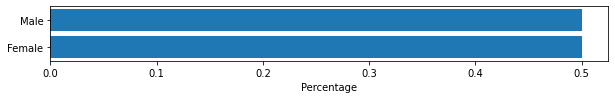

In [8]:
plt.figure(figsize = (10,1))
plt.barh(target_ratio.index, target_ratio.Percentage)
plt.xlabel('Percentage')
plt.show()

In [9]:
con = data[['forehead_width_cm','forehead_height_cm']]
cat = data[['long_hair','nose_wide','nose_long','lips_thin','distance_nose_to_lip_long']]

In [10]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(con)

In [11]:
X_std

array([[-1.24793291,  0.28397148],
       [ 0.73938869, -1.00941773],
       [-1.24793291,  0.65351125],
       ...,
       [-0.25427211, -0.45510807],
       [ 0.01672629,  0.46874136],
       [ 2.00404789, -1.00941773]])

In [12]:
std_data = pd.DataFrame(data=X_std, index=con.index, columns=con.columns)

In [13]:
std_data

,forehead_width_cm,forehead_height_cm
0,-1.247933,0.283971
1,0.739389,-1.009418
2,-1.247933,0.653511
3,1.100720,0.283971
4,0.287725,-0.085568
...,...,...
4996,0.378057,-1.563727
4997,-1.157600,-1.009418
4998,-0.254272,-0.455108
4999,0.016726,0.468741


In [14]:
input_features = pd.concat([std_data,cat],axis=1)
input_features

,forehead_width_cm,forehead_height_cm,long_hair,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long
0,-1.247933,0.283971,1,1,0,1,1
1,0.739389,-1.009418,0,0,0,1,0
2,-1.247933,0.653511,0,1,1,1,1
3,1.100720,0.283971,0,0,1,1,1
4,0.287725,-0.085568,1,0,0,0,0
...,...,...,...,...,...,...,...
4996,0.378057,-1.563727,1,0,0,0,0
4997,-1.157600,-1.009418,1,0,0,0,0
4998,-0.254272,-0.455108,1,0,0,0,0
4999,0.016726,0.468741,1,0,0,0,0


In [15]:
input_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   forehead_width_cm          5001 non-null   float64
 1   forehead_height_cm         5001 non-null   float64
 2   long_hair                  5001 non-null   int64  
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 273.6 KB


In [16]:
lb = LabelEncoder()
data.gender = lb.fit_transform(data.gender)

In [17]:
X = input_features.copy()
y = data.gender

In [18]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=124)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3500, 7)
(1501, 7)
(3500,)
(1501,)


**GradientBoosting Classifier**

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
gb_clf = GradientBoostingClassifier(learning_rate=0.5,n_estimators=1000)

In [21]:
gb_clf.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, n_estimators=1000)

In [22]:
gb_pred=gb_clf.predict(x_test)

0.9673550966022652



Confusion matrix for GradientBoostingClassifier


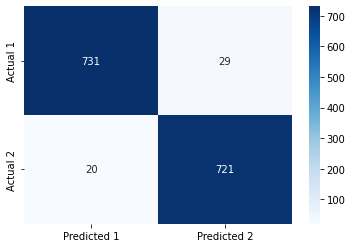



 Classification report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       760
           1       0.96      0.97      0.97       741

    accuracy                           0.97      1501
   macro avg       0.97      0.97      0.97      1501
weighted avg       0.97      0.97      0.97      1501



In [23]:
print(metrics.accuracy_score(y_test,gb_pred))
print('\n\n')
print('Confusion matrix for GradientBoostingClassifier')
gb_cm=metrics.confusion_matrix(y_test, gb_pred)


lbl1=["Predicted 1", "Predicted 2"]
lbl2=["Actual 1", "Actual 2"]

sns.heatmap(gb_cm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('\n\n Classification report')
print(metrics.classification_report(y_test,gb_pred))

**XG Boost**

In [24]:
from xgboost.sklearn import XGBClassifier

In [25]:
xgb_model = XGBClassifier(num_class=1,
                          objective='binary:logistic',
                          eval_metric='logloss',
                          seed=42)

In [26]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=1, num_parallel_tree=None, predictor=None, ...)

In [27]:
xgboost_pred = xgb_model.predict(x_test)

0.966022651565623



Confusion matrix for XG Boost Classifier


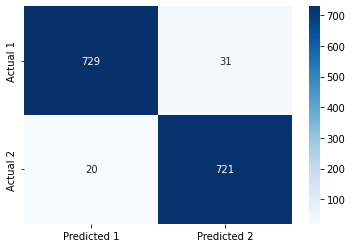



 Classification Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       760
           1       0.96      0.97      0.97       741

    accuracy                           0.97      1501
   macro avg       0.97      0.97      0.97      1501
weighted avg       0.97      0.97      0.97      1501



In [28]:
print(metrics.accuracy_score(y_test,xgboost_pred))
print('\n\n')
print('Confusion matrix for XG Boost Classifier')
xgboost_cm = metrics.confusion_matrix(y_test, xgboost_pred)

lbl1 = ["Predicted 1", "Predicted 2"]
lbl2 = ["Actual 1", "Actual 2"]

sns.heatmap(xgboost_cm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('\n\n Classification Report')
print(metrics.classification_report(y_test,xgboost_pred))

In [29]:
predict_probabilities = xgb_model.predict_proba(x_test)
from sklearn.metrics import roc_auc_score
final_metric = roc_auc_score(y_test, predict_probabilities[:,1])
print(final_metric)

0.9950688969387029


**XGBoost with Grid Search**

In [33]:
from xgboost.core import Objective
xgb_gs_clf = XGBClassifier(num_class = 1,
                           Objective="binary:logistic",
                           eval_metric="logloss",
                           seed=42)

param_grid = {"max_depth": [10,15,20],
             "n_estimators": range(5,20,5),
             "gamma": [0.03,0.05],
             "learning_rate": [0.01,0.05]}

grid_search = GridSearchCV(xgb_gs_clf,
                           param_grid=param_grid,
                           cv = 5,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(x_train,y_train)
grid_search.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[18:00:18] WARNING: ../src/learner.cc:767: 
Parameters: { "Objective" } are not used.



{'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 15}

In [34]:
xgboost_y_pred = grid_search.predict(x_test)

0.9706862091938707


 Confusion matrix for optimal XG Boost Classifier


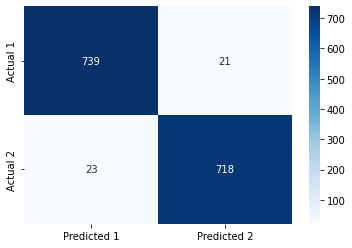




 Classification Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       760
           1       0.97      0.97      0.97       741

    accuracy                           0.97      1501
   macro avg       0.97      0.97      0.97      1501
weighted avg       0.97      0.97      0.97      1501



In [35]:
print(metrics.accuracy_score(y_test,xgboost_y_pred))
print('\n\n Confusion matrix for optimal XG Boost Classifier')
xgboost_cfm = metrics.confusion_matrix(y_test, xgboost_y_pred)

lbl1 = ["Predicted 1", "Predicted 2"]
lbl2 = ["Actual 1", "Actual 2"]

sns.heatmap(xgboost_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('\n\n\n Classification Report')
print(metrics.classification_report(y_test,xgboost_y_pred))

In [37]:
predict_probabilities = grid_search.predict_proba(x_test)
final_metric = roc_auc_score(y_test, predict_probabilities[:,1])
print(final_metric)

0.9922464308544641
